
EE4414 Team Practice
==============================================

In this team practice, you will design Convolutional Neural Network(s) to classify food images.




In [3]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()   # interactive mode

## 1. Loading data

Define the dataset, dataloader, and the data augmentation pipeline.

The code below loads 5 classes from all 12 classes in the dataset. You need to modify it to load only the classes that you need.

***Note: For correctly assessing your code, do not change the file structure of the dataset. Use Pytorch data loading utility (`torch.utils.data`) for customizing your dataset.***

In [4]:
# Define the dataset class
directory = "sg_food"

class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target


In [7]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

data_dir = os.path.join('data', 'sg_food')
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset (TO augment)
selected_classes = [0,2,3,7,8,9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 2, 3, 7, 8, 9]
    name: ['Bak Chor Mee', 'Chicken Rice', 'Hokkien Prawn Mee', 'Oyster Omelette', 'Roast Meat Rice', 'Roti Prata']


## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



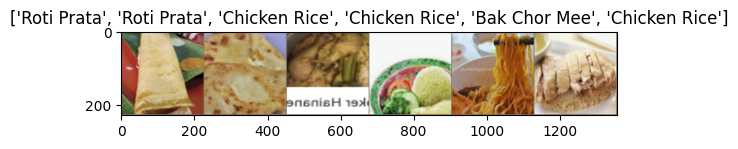

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:6])

imshow(out, title=[class_names[x] for x in classes[:6]])

## 3. Defining function to train the model

Use a pre-trained CNN model with transfer learning techniques to classify the 5 food categories.

(Note: The provided code is only for reference. You can modify the code whichever way you want.)


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=24):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        t1 = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        t2=time.time()
        print('Time:'+str(t2-t1))
        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# MODEL1: 

In [ ]:
# Hello there this is model 1
model1 = 2
dummy_update = 2

# MODEL2:

# MODEL3: 

# MODEL4: ResNet50

## 4. Training and validating the model

Train your model for minimum 3 epochs.

### 4.1 Loading pretrained model and defining new classfier layer


In [7]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

# (code)
model_resnet50 = torchvision.models.resnet50(pretrained=True)
for param in model_resnet50.parameters():
    param.requires_grad = False

# 2. Modify the pretrain model for your task.
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 6)

model_resnet50 = model_resnet50.to(device)

# 3. Choose your loss function, optimizer, etc.
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_resnet50.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


### 4.2 Printing and visualizing the modified model

In [8]:
# TODO
# print(model)
print(model_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# TODO
# from torchsummary import summary
# summary(model, input_size=xxx)
from torchsummary import summary
summary(model_resnet50, input_size=(3, 224, 224)) # Here the input size is channel x width x height

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### 4.3 Training using train data and evaluating using validation data

Train your model for minimum 3 epochs.

In [10]:
# TODO 
model_resnet50 = train_model(model_resnet50, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.7997 Acc: 0.1933
val Loss: 1.7276 Acc: 0.2444
Time:67.08616232872009

Epoch 1/9
----------
train Loss: 1.7077 Acc: 0.3217
val Loss: 1.5832 Acc: 0.5611
Time:69.29319500923157

Epoch 2/9
----------
train Loss: 1.5600 Acc: 0.5033
val Loss: 1.4492 Acc: 0.6278
Time:73.27585411071777

Epoch 3/9
----------
train Loss: 1.4355 Acc: 0.6067
val Loss: 1.3273 Acc: 0.7111
Time:74.57746052742004

Epoch 4/9
----------
train Loss: 1.3443 Acc: 0.6183
val Loss: 1.2293 Acc: 0.7389
Time:74.84570217132568

Epoch 5/9
----------
train Loss: 1.2376 Acc: 0.6733
val Loss: 1.1471 Acc: 0.7722
Time:77.84757280349731

Epoch 6/9
----------
train Loss: 1.1703 Acc: 0.6917
val Loss: 1.0727 Acc: 0.7944
Time:72.36350607872009

Epoch 7/9
----------
train Loss: 1.1066 Acc: 0.7483
val Loss: 1.0612 Acc: 0.8056
Time:71.4419264793396

Epoch 8/9
----------
train Loss: 1.1212 Acc: 0.7417
val Loss: 1.0568 Acc: 0.7889
Time:71.93232369422913

Epoch 9/9
----------
train Loss: 1.0953 Acc: 0.7550
val 

## 5. Loading test data

Define the dataset and dataloader for testing.

In [11]:
test_dir = os.path.join('data', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

## 6. Visualizing the predictions

Predict the label on a few testing samples and visualize the results.

In [12]:
# TODO

# num_images = 4

# (code)

# with torch.no_grad():
    # Predict on the test set

    # (code)

    # Print the output images and labels
    
    # (code)
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

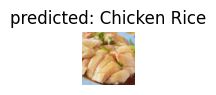

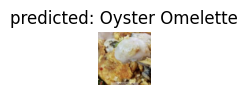

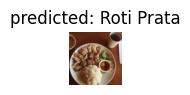

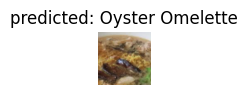

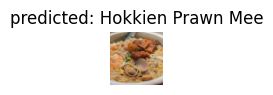

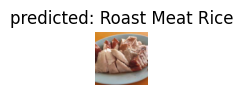

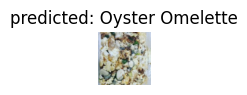

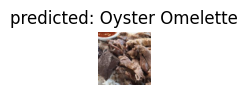

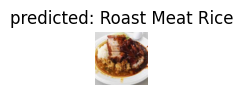

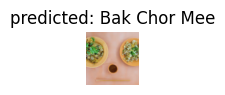

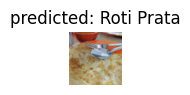

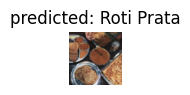

In [13]:
visualize_model(model_resnet50)

plt.ioff()
plt.show()

## 7. Evaluating on test set

Evaluate your model on the whole test set and compute the accuracy.

In [14]:
model_resnet50.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnet50(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.7389


# ResNet18

In [9]:
# 1. Load the pretrained model and extract the intermediate features.
# Tips:     Use torchvision.models
#           https://pytorch.org/vision/stable/models.html#classification

# (code)
model_resnet18 = torchvision.models.resnet18(pretrained=True)
for param in model_resnet18.parameters():
    param.requires_grad = False

# 2. Modify the pretrain model for your task.
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 6)

model_resnet18 = model_resnet18.to(device)

# 3. Choose your loss function, optimizer, etc.
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_resnet18.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [11]:
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
from torchsummary import summary
summary(model_resnet18, input_size=(3, 224, 224)) # Here the input size is channel x width x height

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [12]:
model_resnet18 = train_model(model_resnet18, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.9097 Acc: 0.2083
val Loss: 1.8235 Acc: 0.2278
Time:20.458675146102905

Epoch 1/9
----------
train Loss: 1.7707 Acc: 0.2317
val Loss: 1.6597 Acc: 0.3444
Time:19.604292154312134

Epoch 2/9
----------
train Loss: 1.6116 Acc: 0.3867
val Loss: 1.5148 Acc: 0.4556
Time:19.422496795654297

Epoch 3/9
----------
train Loss: 1.4638 Acc: 0.4833
val Loss: 1.3883 Acc: 0.5333
Time:20.070125579833984

Epoch 4/9
----------
train Loss: 1.3576 Acc: 0.5583
val Loss: 1.2832 Acc: 0.6111
Time:19.054362297058105

Epoch 5/9
----------
train Loss: 1.2487 Acc: 0.6050
val Loss: 1.2063 Acc: 0.6222
Time:19.259782075881958

Epoch 6/9
----------
train Loss: 1.1865 Acc: 0.6333
val Loss: 1.1314 Acc: 0.6667
Time:19.376036882400513

Epoch 7/9
----------
train Loss: 1.1550 Acc: 0.6550
val Loss: 1.1247 Acc: 0.6722
Time:20.338945150375366

Epoch 8/9
----------
train Loss: 1.1262 Acc: 0.6733
val Loss: 1.1227 Acc: 0.6611
Time:19.442747592926025

Epoch 9/9
----------
train Loss: 1.1506 Acc: 0

In [15]:
test_dir = os.path.join('data', 'sg_food', 'test')

# Define the test set.
test_dataset = sg_food_dataset(root=test_dir, class_id=selected_classes, transform=data_transforms['val'])
test_sizes = len(test_dataset)

# Define the dataloader for testing.
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)

In [16]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

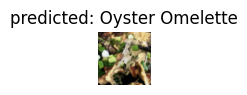

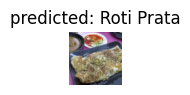

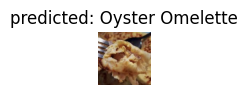

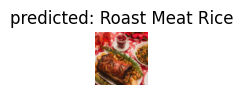

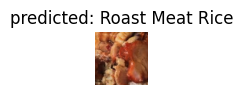

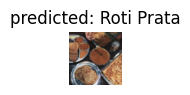

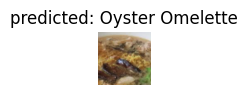

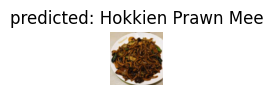

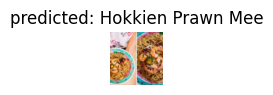

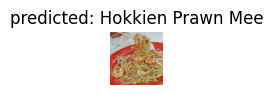

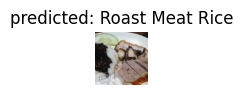

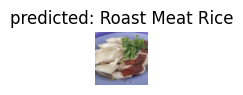

In [17]:
visualize_model(model_resnet18)

plt.ioff()
plt.show()

In [18]:
model_resnet18.eval()

test_acc = 0

print('Evaluation')
print('-' * 10)

with torch.no_grad():
    # Iterate over the testing dataset.
    for (inputs, labels) in test_loader:
        inputs = inputs.to(device)
        # Predict on the test set
        outputs = model_resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu()
        test_acc += torch.sum(preds == labels.data)

# Compute the testing accuracy
test_acc = test_acc.double() / test_sizes
print('Testing Acc: {:.4f}'.format(test_acc))


Evaluation
----------
Testing Acc: 0.6847


## ResNet50 vs ResNet18 at 10 Epochs
### ResNet50: Testing Acc: 0.7389
### ResNet18: Testing Acc: 0.6847